In [8]:
import edward as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from edward.models import OneHotCategorical, Normal

In [3]:
tf.flags.DEFINE_integer("N", default=40, help="Number of data points.")
tf.flags.DEFINE_integer("D", default=2, help="Number of features.")
tf.flags.DEFINE_integer("T", default=5000, help="Number of posterior samples.")

FLAGS = tf.flags.FLAGS

In [4]:
def build_toy_dataset(N, D, noise_std=0.1):
    n_half = N//2
    X1 = np.random.multivariate_normal(mean=np.ones(D) + 1.0, cov=np.eye(D), size=n_half)
    X2 = np.random.multivariate_normal(mean=np.ones(D) - 1.0, cov=np.eye(D), size=N - n_half)
    y = np.array([[1, 0] if i < n_half else [0, 1] for i in range(N)])
    X = np.vstack((X1, X2))
    return X, y

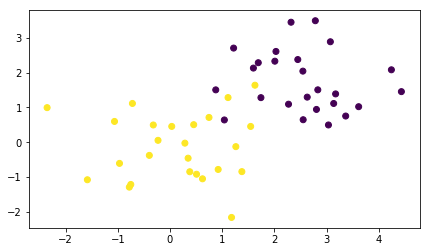

In [9]:
# data visualize
X, y = build_toy_dataset(50, 2)
fig = plt.figure(figsize=(7, 4))
plt.scatter(X[:, 0], X[:, 1], c=[elem.argmax() for elem in y])

In [10]:
def main():
    # DATA
    X_train, y_train = build_toy_dataset(FLAGS.N, FLAGS.D)
    print("X: ", X_train.shape)
    print("y: ", y_train.shape)
    # MODEL
    X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
    w = Normal(loc=tf.zeros([FLAGS.D, FLAGS.D]), scale=3.0 * tf.ones([FLAGS.D, FLAGS.D]))
    y = OneHotCategorical(logits=tf.matmul(X, w))

    # Alternatively, use variational inference.
    qw_loc = tf.get_variable("qw_loc", [FLAGS.D, FLAGS.D])
    # sofplus = log(1 + exp(x))
    qw_scale = tf.nn.softplus(tf.get_variable("qw_scale", [FLAGS.D, FLAGS.D]))
    
    qw = Normal(loc=qw_loc, scale=qw_scale)

    inference = ed.KLqp({w: qw}, data={X: X_train, y: y_train})
    inference.initialize(n_print=10, n_iter=600)
    
    # init
    tf.global_variables_initializer().run()
    
    # Build samples from inferred posterior.
    n_samples = 50
    inputs, _ = build_toy_dataset(n_samples, FLAGS.D)
    probs = tf.stack([tf.nn.softmax(ed.dot(inputs, qw.sample()))
                      for _ in range(n_samples)])
    
    # Set up figure.
    fig = plt.figure(figsize=(8, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.ion()
    plt.show(block=False)
    
    for t in range(inference.n_iter):
        info_dict = inference.update()
        inference.print_progress(info_dict)

        if t % inference.n_print == 0:
            outputs = probs.eval()

            # Plot data and functions
            plt.cla()
            ax.scatter(X_train[:, 0], X_train[:, 0], c=[elem.argmax() for elem in y_train])
            for s in range(n_samples):
                ax.scatter(inputs[:, 0], inputs[:, 1], c=outputs[s].argmax(), alpha=0.2)

            ax.set_xlim([-5, 3])
            ax.set_ylim([-0.5, 1.5])
            plt.draw()
            plt.pause(1.0 / 60.0)

In [11]:
ed.set_seed(42)

In [12]:
tf.reset_default_graph()
main()

UnrecognizedFlagError: Unknown command line flag 'f'